In [126]:
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import numpy as np
import cPickle

from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

tf.logging.set_verbosity(tf.logging.INFO)

num_classes=10
dropout_rate=0.4

def unpickle(file_name):
    with open(file_name, 'rb') as fo:
        data = cPickle.load(fo)
    return data

def cnn_model(features, labels, mode):
    input_data = tf.reshape(features, [-1, 3, 32, 32])
    input_layer = tf.to_float(input_data)
    conv1_layer = tf.layers.conv2d(inputs=input_layer,
                                  filters=40,
                                  kernel_size=(5,5),
                                  strides=(2,2),
                                  padding='same',
                                  data_format='channels_first',
                                  activation=tf.nn.relu)
    pool1_layer = tf.layers.max_pooling2d(inputs=conv1_layer,
                                         pool_size=(2,2),
                                         strides=(2,2),
                                         padding='same',
                                         data_format='channels_first')
    conv2_layer = tf.layers.conv2d(inputs=pool1_layer,
                                  filters=80,
                                  kernel_size=(3,3),
                                  strides=(1,1),
                                  padding='same',
                                  data_format='channels_first',
                                  activation=tf.nn.relu)
    pool2_layer = tf.layers.max_pooling2d(inputs=conv2_layer,
                                         pool_size=(2,2),
                                         strides=(2,2),
                                         padding='same',
                                         data_format='channels_first')
    pool2_flat = tf.reshape(pool2_layer, [-1, 80*4*4])
    dense1 = tf.layers.dense(pool2_flat, units=400, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense1, 
                                rate=dropout_rate, 
                                training=mode==learn.ModeKeys.TRAIN)
    classes = tf.layers.dense(inputs=dropout, units=num_classes)
    print(classes)
    return

In [123]:
data = unpickle('dataset/cifar-10-batches-py/data_batch_1')

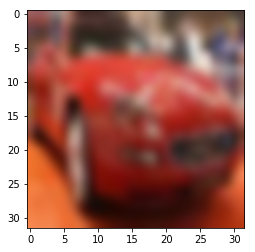

In [124]:
image = np.reshape(data['data'][5], [3, 1024])
image_reordered = []
for i in range(1024):
    image_reordered.append([image[0][i], image[1][i], image[2][i]])

image_reordered = np.reshape(image_reordered, [32, 32, 3])
plt.imshow(image_reordered, shape=(32,32), interpolation='bicubic')

In [127]:
cnn_model(image, 0, 0)

Tensor("dense_5/BiasAdd:0", shape=(1, 10), dtype=float32)
